<a href="https://colab.research.google.com/github/aditj/IRS-Paper/blob/master/IRS_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
# helper
from functools import wraps
import time

# math
import numpy as np
import scipy.io
import math

#plotting
import matplotlib.pyplot as plt

## Helper Functions

We can sample the Channel coefficients from a rician distribution with parameters $\beta$ and $K$. $\mathbf{h_d}$ is constant and $\mathbf{h_s}$ is sampled form a circularly symmetric standard Complex Gaussian  
$$\mathbf{h} = \sqrt{\frac{\beta K}{1+K}} \mathbf{h_d} + \sqrt{\frac{\beta }{1+K}} \mathbf{h_s}$$

In [ ]:
# get the channel coefficients from the rician distribution
def rician(beta,k,h_d=0 ,num_carriers=500,num_channels=1):
    """
    returns a (num_carriers x num_channels) matrix with complex numbers whose magnitude would follow a rician distribution 
    beta is a distance dependent path loss parameter 
    K is ratio of deterministic to scattered power
    """
    det = math.sqrt(beta*k/(1+k))* h_d
    det = np.tile(det,(1,num_carriers)).T
    ran = math.sqrt(beta/((1+k)*2)) * np.random.randn(num_carriers, num_channels*2).view(np.complex128)
    return ran+det

In [ ]:
def theta_direct(N,phi=np.pi/3,d=0.06): 
    # What does phi mean again
    return 2*np.pi*d* np.arange(1,N+1)*np.cos(phi)
    
def theta_reflector(Nx,Ny,phi=np.pi/3,d=0.06/4): 
    # Nx = Number of columns in IRS
    # Ny = Number of rows
    # What is the significance of Phi here?
    yv,xv=np.meshgrid(np.arange(Nx),np.arange(Ny), sparse=False, indexing='ij')
    dist=np.sqrt(xv**2+yv**2)
    return 2 * np.pi * d * dist * np.cos(phi)

def generate_deterministic_direct(antenna_gains):
    
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_direct(antenna_gains.shape[0]))*alphas

def generate_deterministic_reflectors(antenna_gains):
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_reflector(antenna_gains.shape[0],antenna_gains.shape[1]))*alphas


In [ ]:
generate_deterministic_direct(np.ones(1))
generate_deterministic_direct(np.ones(1))


(16, 16)

In [ ]:
# we can append @timer to each of our function for which we want to have the time printed
def timer(func):
    """
    Usage:
    @timer
    def somefunc(a,b):
        output = a+b
        return output
    """
    @wraps(func)
    def wrapper(*args,**kwargs):
        print(f"{func.__name__!r} begins")
        start_time = time.time()
        result = func(*args,**kwargs)
        print(f"{func.__name__!r} ends in {time.time()-start_time} secs")
        return result
    return wrapper

In [ ]:
# get IRS configuration
def get_config(method = None):
    if method == None:
        return np.exp(2j*np.random.randint(M,size=N_e)*np.pi/M)

In [ ]:
# calculate the datarate for the given configuration of IRS
def calculate_datarate(H,x):
    indi=np.log2(1+(np.square(np.abs(H)))*abs(np.square(x).sum())/10**-14)
    return np.sum(indi)*10**6

In [ ]:
# vector method
def return_coefficients(h_,opt,M=2):
    angles = M - np.round((np.angle(opt/h_)*M/(2*np.pi))%np.pi)
    angles[0] = 0
    return np.exp(2j*angles*np.pi/M)

def vector_heuristic(h,M=2):
    h_ = h.sum(axis=0)
    idx = np.argmax(np.abs(h_))

    return return_coefficients(h_,h_[idx],M)

In [ ]:
#Greedy approach

In [ ]:
def return_greedy_estimate(estimation,N_regions=4,M=2):
    estimation_sum = estimation.sum(axis=0)
    opt = np.exp(2j*np.asarray(range(M))*np.pi/M)
    angles = np.ones((estimation_sum.shape[0],N_regions)).astype(complex)
    for i in range(len(opt)):
        angles[:,i] = return_coefficients(estimation_sum,opt[i],M)
    abso=np.abs(np.matmul(angles.T,estimation_sum.reshape((-1,1))))
    opt_angle=angles[:,np.where((angles[0,:]==1) &(abso==np.max(abso)))[0]][:,0].flatten()
    return opt_angle

In [ ]:
def strongest_tap(est,n_strong,N_e,K,L,N_regions=40,M=2):
    time_h = np.fft.ifft(est,K,axis=0)[:L,:]
    strongest_tap = np.argsort(np.abs(time_h),axis=0)[-1*n_strong:,:].reshape(N_e,n_strong)
    top_time_h = np.zeros((n_strong,N_e),dtype=complex)
    for i in range(N_e):
        top_time_h[:,i] = time_h[strongest_tap[i],i]
    h = np.fft.fft(top_time_h,500,axis=0) # FFT 
    theta = return_greedy_estimate(h,N_regions,M) # Try out different stats
    return theta

## System Parameters

In [ ]:
# General parameters
K = 500 # sub carriers
L = 20 # taps

M = 2 #Num of discrete phase-shifts
N_x = 16
N_y = 16
N_e = N_x * N_y #Number of IRS elements

# Channel information
#direct channel
beta_d = (10)**-3 * (10)**-3
k_d = 0
const_d = 0
#BS to IRS channel
beta_bi =  (10)**-3 * (1.5)**-3
k_bi = 1
const_bi = 0
#IRS to User channel
beta_iu =  (10)**-3 * (8)**-3
k_iu = 1
const_iu = 0

## Declaring variables

In [ ]:
det = generate_deterministic_reflectors(np.ones((N_x,N_y))).reshape((N_e,1))
det_direct = generate_deterministic_direct(np.ones(1))[0]
# CSI

H_d = rician(beta=beta_d, k=k_d,num_carriers=K,h_d=det_direct)
H_bi = rician(beta=beta_bi,k=k_bi,num_carriers=K,num_channels=N_e,h_d=det)
H_iu = rician(beta=beta_iu,k=k_iu,num_carriers=K,num_channels=N_e,h_d=det)

## Theta

IRS_config = get_config()
Direct = np.ones(1).astype(np.complex128)
Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))


## Final channel

H_id = np.multiply(H_bi,H_iu)
H = np.concatenate((H_d,H_id), axis=1)
G_comp = H * Theta.T ## Channel Across different subcarriers and subchannels
G = H @ Theta ## Final  Channel across different subcarriers

def calculate_cascaded(H,Theta):
    Theta = Theta.reshape((N_e+1,1))
    G = H @ Theta ## Final  Channel across different subcarriers
    return G    





## Creating Signal 

In [ ]:
## Power Distribution over different subcarriers: 
P = np.random.dirichlet(np.ones(K),size=1)
P_max = 10 ## Power Budget in mW
## Symbol to be sent of 1mW
s = 1e-3 * P_max
w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
x= w*s # Final Symbol Transmitted
x = x * P.T

In [ ]:
np.square(x).sum() ## VERIFY SIGNAL POWER!

(3.669068326888214e-07-5.8068175450904e-08j)

## Transmitting the Signal

In [ ]:
y = x * G 

## Data Rate Expression

In [ ]:
Theta = strongest_tap(H,1,N_e+1,K,L)
#Theta = vector_heuristic(H,M)
G = calculate_cascaded(H,Theta)
R = calculate_datarate(G,x)

(500, 257)


In [ ]:
R/10**8

40.97576780857417

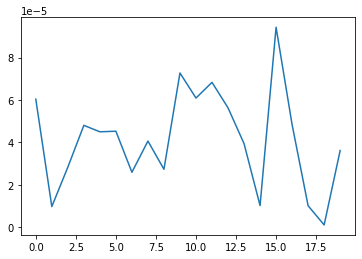

In [ ]:
time_h = np.fft.ifft(H,K,axis=0)[:L,:]
plt.plot(np.abs(time_h[:,0]))

In [ ]:
estimate = np.load("/work/IRS-Paper/estimate_d1.npy")

In [ ]:
estimate.shape

(500, 4097)

In [ ]:
N_e = 4096
#Theta = strongest_tap(estimate,1,N_e+1,K,L)
Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

0.2142596565170049

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b319ffc-f2ce-4490-9e28-3a7eb21abad0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>